In [1]:
%config InlineBackend.figure_formats=['svg']
import numpy as np
import scipy
import scipy.sparse as sparse
import cvxpy as cp
import matplotlib.pyplot as plt
import only_prop_only_nuclear_norm as api
import time
import math

np.random.seed(0)

In [4]:
N_omega = 21
free_indices = 2*N_omega - 1 - 12
omega = np.linspace(-2, 2, N_omega)
delta_omega = np.abs(omega[1] - omega[0])
N_z = 6
z = np.linspace(0, 5*10**-3, N_z)
delta_z = np.abs(z[1] - z[0])
green_fs = api.get_green_f(omega,z)
projection = np.zeros((N_omega, N_omega))
projections = []
sdr_def_constr = []
B_dagger_B_constr = []
sdr_cst = []

for i in range(N_omega):
    for j in range(N_omega):
        proj_copy = projection.copy()
        proj_copy[i, j] = 1
        projections.append(sparse.csc_matrix(proj_copy))
        sdr_def_constr.append(api.sdr_def_constr(N_omega, N_z, sparse.csc_matrix(proj_copy)))
        quad = api.diag_mat(N_omega, N_z, proj_copy)[0] + api.diag_mat(N_omega, N_z, proj_copy)[0].conj().T
        quad.resize(((2*N_z + 1)*N_omega,(2*N_z + 1)*N_omega))
        B_dagger_B_constr.append(quad)
        if i == j:
            sdr_cst.append(2.)
        else:
            sdr_cst.append(0.)

In [8]:
beta_vec = np.exp(-np.linspace(omega[0], omega[-1], 2*N_omega - 1)**2/2.1)#np.array(list(np.zeros(N_omega//2)) + list(np.random.random(N_omega)) + list(np.zeros(N_omega//2)))
#np.array([0., 0.] + list(np.random.random(2*N_omega - 5)) + [0., 0.])
#1.916*np.exp(-np.linspace(omega[0], omega[-1], 2*N_omega - 1)**2/1.995)
#
#np.array([0., 0., 0.] + list(np.random.random(2*N_omega - 7)) + [0., 0., 0.])
#np.array([2.10900246, 2.10794203, 2.10786931, 2.10829837, 2.10790335,
       #2.1076864 , 2.10778626, 2.1078306 , 2.10778798, 2.10783712,
       #2.10781799, 2.1078467 , 2.10784045, 2.10769124, 2.10781962,
       #2.10769124, 2.10784045, 2.1078467 , 2.10781799, 2.10783712,
       #2.10778798, 2.1078306 , 2.10778626, 2.1076864 , 2.10790335,
       #2.10829837, 2.10786931, 2.10794203, 2.10900246])
#np.array(list((0.1/decay_curve)*np.exp(np.linspace(0, position*delta_omega, position))) + list(0.1 + np.exp(-np.linspace(omega[position], omega[len(omega) - 1 - position], 2*N_omega - 1 - 2*position)**2)) + list((0.1/decay_curve)*np.exp(np.linspace(position*delta_omega, 0, position))))
beta = scipy.linalg.hankel(beta_vec[:N_omega], beta_vec[N_omega - 1:])
new_beta = delta_omega*beta/(np.sqrt(np.trace(beta@beta)))
beta_weight = 100.
delta_k = 1.j*np.diag(omega)
Q_plus = delta_k + beta_weight*new_beta
Q_minus = delta_k - beta_weight*new_beta
n = 0.25*np.trace((scipy.linalg.expm(Q_plus*z[-1]) - scipy.linalg.expm(Q_minus*z[-1])).conj().T@(scipy.linalg.expm(Q_plus*z[-1]) - scipy.linalg.expm(Q_minus*z[-1])))
W_plus = [(1/np.sqrt(n))*scipy.linalg.expm(Q_plus*z[i]) for i in range(1, N_z)]
W_minus = [(1/np.sqrt(n))*scipy.linalg.expm(Q_minus*z[i]) for i in range(1, N_z)]
X = np.vstack(W_plus + W_minus + [new_beta])
Y = np.vstack(W_plus + W_minus + [new_beta, np.eye(N_omega)])
full_rank = Y@Y.conj().T
n

(0.010029083803918898+0j)

In [9]:
# Creates the matrix for the hermite basis superposition
max_order = 10
width = 0.1
hermite_mat = api.get_hermite_polynom_mat(omega, max_order, width)

In [10]:
# Generate constraints
#n = 0.5
#beta_weight = 60.
dynamics_constr = []
sympl_constr = []
pump_fix_constr = []
lin_dynamics = []
lin_dynamics_accurate = []
quad_symplect = []
gen_symplect = []
fin_diff_quad_lin_plus = []
fin_diff_quad_lin_minus = []
lin_dynamics_more_accurate = []
# Changed the constraint to be tr(VV) = delta_omega**2
pump_power_constr = api.limit_pump_power(omega, N_z)
photon_end_nbr_constr = api.photon_nbr_constr(N_omega, N_z, n)
photon_prev_ineq_constr = api.photon_nbr_prev_points(N_omega, N_z)
pump_hankel_constr = api.constr_hankel_sdr(N_omega, N_z)
fixed_first_last_row = api.constr_first_last_row_pump(N_omega, N_z, new_beta, free_indices)
basic_ineq_on_pump_high, basic_ineq_on_pump_low = api.basic_affine_ineq_pump(N_omega, N_z, free_indices, 0.3)
constr_left_decay, constr_right_decay = api.pump_exp_decay_constr(N_omega, N_z, "positive", "positive", 5, 20, max_ampli=0.01)
for i in range(len(projections)):
    real_plus_dyn, imag_plus_dyn, real_minus_dyn, imag_minus_dyn = api.get_dynamics_sdr(omega, z, projections[i], n, beta_weight)
    real_sympl, imag_sympl = api.sympl_constr_sdr(N_omega, N_z, projections[i], n)
    real_fixed_pump, imag_fixed_pump = api.sdr_fixed_pump(N_omega, N_z, new_beta, projections[i])
    dynamics_constr += real_plus_dyn + imag_plus_dyn + real_minus_dyn + imag_minus_dyn
    sympl_constr += real_sympl + imag_sympl
    lin_dynamics += api.lin_finite_diff_constr(z, N_omega, delta_k, n, beta_weight, projections[i])
    lin_dynamics_accurate += api.lin_finite_diff_constr_accurate(z, N_omega, delta_k, n, beta_weight, projections[i])
    lin_dynamics_more_accurate += api.lin_finite_diff_constr_more_accurate(z, N_omega, delta_k, n, beta_weight, projections[i])
    quad_symplect += api.constr_lower_quadratic_prop_sympl(N_omega, N_z, projections[i]) + api.constr_upper_quadratic_prop_sympl(N_z, N_omega, projections[i])
    gen_symplect += api.constr_sympl_plus(N_z, N_omega, n, projections[i]) + api.constr_sympl_minus(N_z, N_omega, n, projections[i])
    fin_diff_quad_lin_plus += api.constr_fin_diff_quad_lin_plus(N_omega, z, beta_weight, n, delta_k, projections[i])
    fin_diff_quad_lin_minus += api.constr_fin_diff_quad_lin_minus(N_omega, z, beta_weight, n, delta_k, projections[i])
    pump_fix_constr += [imag_fixed_pump]#, real_fixed_pump]
constraints_list = dynamics_constr + sympl_constr + pump_hankel_constr + [photon_end_nbr_constr, pump_power_constr] + pump_fix_constr  + fin_diff_quad_lin_plus + fin_diff_quad_lin_minus + quad_symplect + gen_symplect + lin_dynamics + lin_dynamics_accurate + lin_dynamics_more_accurate# + fixed_first_last_row

In [14]:
[(np.trace(Y.conj().T@constraints_list[i]@Y), i) for i in range(len(constraints_list)) if np.abs(np.trace(Y.conj().T@constraints_list[i]@Y)) > 2*10**-5]

[]

In [12]:
# Get matrices to build objective function
left, right = api.obj_f_mat(N_omega, N_z)

In [13]:
# Set constraints to make the nuclear norm of U_+ and U_- less or equal that of the rank 1 problem
left_both = api.get_lin_matrices(N_z, N_omega, sparse.eye(N_omega))[2*N_z - 2]
left_both = sparse.vstack([sparse.csc_matrix((N_omega, N_omega)), left_both])
right_plus = api.get_lin_matrices(N_z, N_omega, sparse.eye(N_omega))[N_z - 2]
right_plus.resize((2*N_z*N_omega, N_omega))
right_minus =  api.get_lin_matrices(N_z, N_omega, sparse.eye(N_omega))[2*N_z - 3]
right_minus.resize((2*N_z*N_omega, N_omega))
# For epsilon = 0.2, the lower bound is 1.10, but only for n = 0.001, which is expected. For epsilon = 0, most likely cant cpnverge
epsilon = .01
cst_plus = (N_omega - 2)/np.sqrt(n) + 1 + np.sqrt(1 + 1/n) +  epsilon/2 + np.sqrt((epsilon**2)/4 + 1/n)
cst_minus = (N_omega - 2)/np.sqrt(n) - .995 + np.sqrt((.995)**2 + 1/n) + epsilon/2 + np.sqrt((epsilon**2)/4 + 1/n)
cst_plus, cst_minus, sum(scipy.linalg.svd(W_plus[-1])[1]),sum(scipy.linalg.svd(W_minus[-1])[1])

((210.7502335577343+0j),
 (208.75473655663038+0j),
 210.4867169748606,
 209.0037790099276)

In [9]:
# Matrices to get the sum of U_+N and U_-N
left_sum_sing_val = api.get_lin_matrices(N_z, N_omega, sparse.eye(N_omega))[N_z - 2] + api.get_lin_matrices(N_z, N_omega, sparse.eye(N_omega))[2*N_z - 3]
left_sum_sing_val.resize((2*N_z*N_omega, N_omega))
right_sum_sing_val = api.get_lin_matrices(N_z, N_omega, sparse.eye(N_omega))[2*N_z - 2]
right_sum_sing_val = sparse.vstack([sparse.csc_matrix((N_omega, N_omega)), right_sum_sing_val])
cst_sum = N_omega*(1/n + 1)/(-1 + np.sqrt(1 + 1/n))

In [22]:
variable = cp.Variable(shape = (2*N_z*N_omega, 2*N_z*N_omega), hermitian = True)
hermite_coeff = cp.Variable(shape=(max_order,))
constraints = [variable >> 0]
constraints += [cp.real(cp.trace(sdr_def_constr[i]@variable)) == sdr_cst[i] for i in range(len(sdr_def_constr))]
constraints += [cp.real(cp.trace(constraints_list[i]@variable)) == 0 for i in range(len(constraints_list))]
constraints += [cp.real(cp.trace(photon_prev_ineq_constr[i]@variable)) >= 0 for i in range(len(photon_prev_ineq_constr))]
# Nuclear norm into SDP
V_plus = cp.Variable(shape = (N_omega, N_omega), hermitian = True)
X_plus = cp.Variable(shape = (N_omega, N_omega), hermitian = True)
V_minus = cp.Variable(shape = (N_omega, N_omega), hermitian = True)
X_minus = cp.Variable(shape = (N_omega, N_omega), hermitian = True)
var_U_plus_dagger = left_both.conj().T@variable@right_plus
var_U_minus_dagger = left_both.conj().T@variable@right_minus
Q_plus = cp.vstack([cp.hstack([V_plus, var_U_plus_dagger]), cp.hstack([var_U_plus_dagger.conj().T, X_plus])])
Q_minus = cp.vstack([cp.hstack([V_minus, var_U_minus_dagger]), cp.hstack([var_U_minus_dagger.conj().T, X_minus])])
constraints.append(Q_plus >> 0)
constraints.append(Q_minus >> 0)
constraints.append(cp.real(cp.trace(V_plus + X_plus)) - 2*cst_plus == 0)
constraints.append(cp.real(cp.trace(V_minus + X_minus)) - 2*cst_minus == 0)
# Constraint on the pump itself
left_first_pump, left_second_pump, right_first_pump, right_second_pump = api.isolate_vect_pump(N_omega, N_z)
#constraints.append(cp.real(cp.hstack([left_first_pump.conj().T@variable@right_first_pump, left_second_pump.conj().T@variable@right_second_pump])) == hermite_mat.T@hermite_coeff)
problem = cp.Problem(cp.Minimize(cp.atoms.norm(left.conj().T@variable@right, "nuc")), constraints)

In [ ]:
problem.solve(solver = cp.MOSEK, mosek_params = {"MSK_IPAR_INTPNT_MAX_ITERATIONS":10**9, "MSK_DPAR_INTPNT_CO_TOL_INFEAS":10**-8, "MSK_IPAR_NUM_THREADS":8, "MSK_DPAR_INTPNT_CO_TOL_DFEAS":10**-4, "MSK_DPAR_INTPNT_CO_TOL_PFEAS":10**-4, "MSK_DPAR_INTPNT_TOL_DFEAS":10**-4}, verbose = True)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) May 10 12:08:24 PM: Your problem has 92500 variables, 65587 constraints, and 0 parameters.
(CVXPY) May 10 12:08:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 10 12:08:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 10 12:08:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 10 12:08:26 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 10 12:08:27 PM: Compiling problem (target solver=MOSE

In [22]:
herm_coeff = hermite_coeff.value

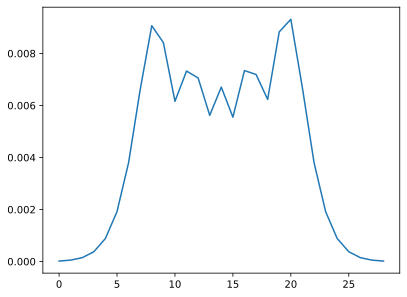

In [23]:
# plot at 150 beta_weight
plt.plot(hermite_mat.T@herm_coeff)

In [11]:
sum(0.5*scipy.linalg.svd(W_plus[-1]  - W_minus[-1])[1])

1.2568597928774037

In [ ]:
# Maybe bc gain not big enough?
# When just constraining on first and last row, it still has strong duality. Wonder if i remove rows one by one what happens?

In [67]:
#end_product = variable.value
U_plus = [end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, i*N_omega:(i + 1)*N_omega] for i in range(N_z - 1)]
U_minus = [end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (N_z - 1 + i)*N_omega:(N_z + i)*N_omega] for i in range(N_z - 1)]
quad_U_plus = [end_product[i*N_omega:(i + 1)*N_omega, i*N_omega:(i + 1)*N_omega] for i in range(N_z - 1)]
quad_U_minus = [end_product[(N_z - 1 + i)*N_omega:(N_z + i)*N_omega, (N_z - 1 + i)*N_omega:(N_z + i)*N_omega] for i in range(N_z - 1)]
pump_U_plus = [end_product[(2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega, i*N_omega:(i + 1)*N_omega] for i in range(N_z - 1)]
opt_pump = end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega]

In [90]:
theoretical_plus = (1/np.sqrt(n))*scipy.linalg.expm((delta_k + beta_weight*opt_pump)*z[-1])
theoretical_minus = (1/np.sqrt(n))*scipy.linalg.expm((delta_k - beta_weight*opt_pump)*z[-1])
np.trace(theoretical_plus@theoretical_plus.conj().T + theoretical_minus@theoretical_minus.conj().T - (2/n)*np.eye(N_omega)) 

(0.05204861274695727+0j)

In [103]:
np.max(np.abs(np.real(theoretical_plus - U_plus[4])))

0.02102964799804985

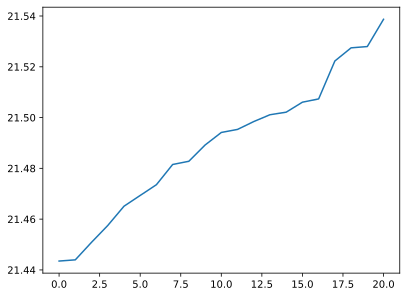

In [85]:
# Last N_omega eigenvalues
plt.plot(scipy.linalg.eigvalsh(end_product)[(2*N_z - 1)*N_omega:])

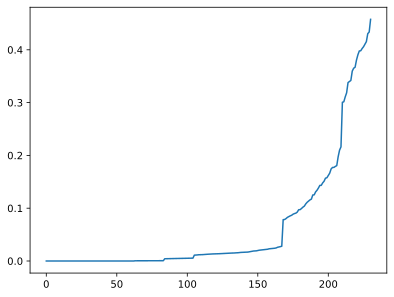

In [88]:
# Number of eigenvalues before last N_omega
plt.plot(scipy.linalg.eigvalsh(end_product)[:(2*N_z - 1)*N_omega])

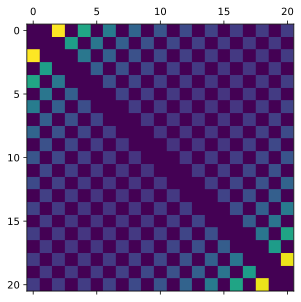

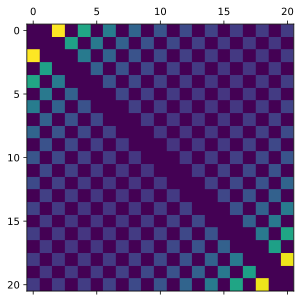

In [59]:
# U_+ U_+ dagger for the optimized result and U_+ U_+ dagger for the result from matrix exponentiation with linear part of pump
test = (1/n)*scipy.linalg.expm((delta_k + beta_weight*opt_pump)*z[-1])@scipy.linalg.expm((delta_k + beta_weight*opt_pump)*z[-1]).conj().T
plt.matshow(np.real(quad_U_plus[4] - np.diag(np.diag(quad_U_plus[4]))))
plt.matshow(np.real(test - np.diag(np.diag(test))))

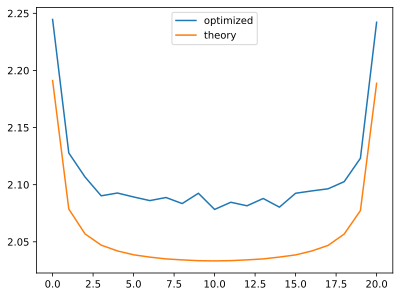

In [60]:
# All about U_+ U_+ dagger
plt.plot(np.diag(quad_U_plus[4]), label = "optimized")
plt.plot(np.diag(test), label = "theory")
plt.legend()

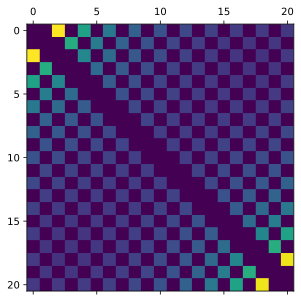

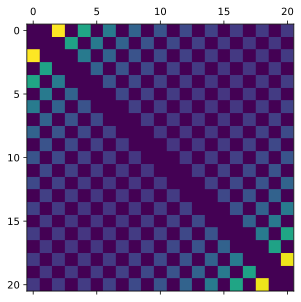

In [65]:
# U_+ dagger for the optimized result and U_+ U_+ dagger for the result from matrix exponentiation with linear part of pump
test = (1/np.sqrt(n))*scipy.linalg.expm((delta_k + beta_weight*opt_pump)*z[-1]).conj().T
plt.matshow(np.real(U_plus[4] - np.diag(np.diag(U_plus[4]))))
plt.matshow(np.real(test - np.diag(np.diag(test))))

/home/jiaqizhao/miniconda3/envs/cvxpy_opt/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


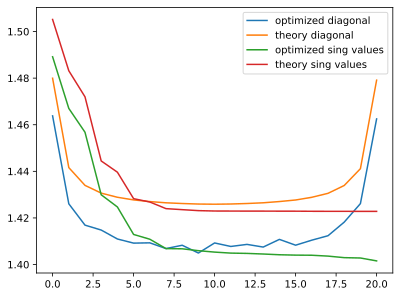

In [66]:
# All about U_+ dagger
plt.plot(np.diag(U_plus[4]), label = "optimized diagonal")
plt.plot(np.diag(test), label = "theory diagonal")
plt.plot(scipy.linalg.svd(U_plus[4])[1], label = "optimized sing values")
plt.plot(scipy.linalg.svd(test)[1], label = "theory sing values")
plt.legend()

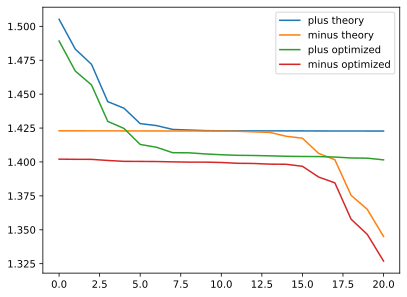

In [16]:
# Singular values of U_+ and U_-, optimized and theoretical
theory_U_plus = (1/np.sqrt(n))*scipy.linalg.expm((delta_k + beta_weight*opt_pump)*z[-1])
theory_U_minus = (1/np.sqrt(n))*scipy.linalg.expm((delta_k - beta_weight*opt_pump)*z[-1])
plt.plot(scipy.linalg.svd(theory_U_plus)[1], label = "plus theory")
plt.plot(scipy.linalg.svd(theory_U_minus)[1], label = "minus theory")
plt.plot(scipy.linalg.svd(U_plus[4])[1], label = "plus optimized")
plt.plot(scipy.linalg.svd(U_minus[4])[1], label = "minus optimized")
plt.legend()

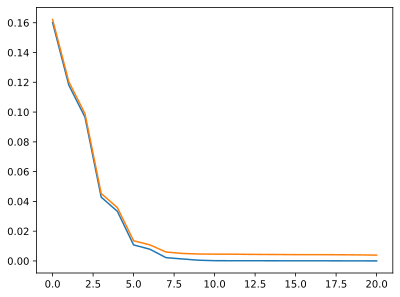

In [17]:
# Singular values of the difference between the exponential and the optimized between U_+ and U_-
plt.plot(scipy.linalg.svd(theory_U_plus - theory_U_minus)[1], label = "plus theory")
plt.plot(scipy.linalg.svd(U_plus[4] - U_minus[4])[1], label = "plus theory")

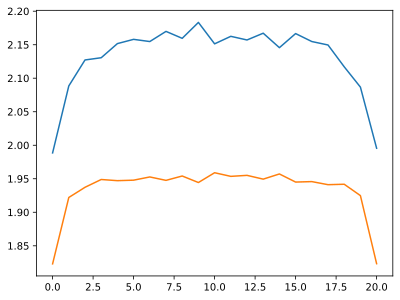

In [18]:
plt.plot(np.diag(quad_U_minus[4]))
plt.plot(np.diag(U_minus[4]@U_minus[4].conj().T))

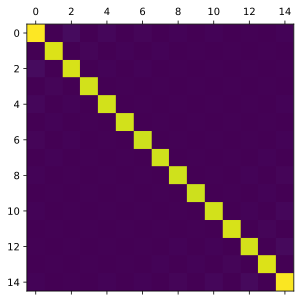

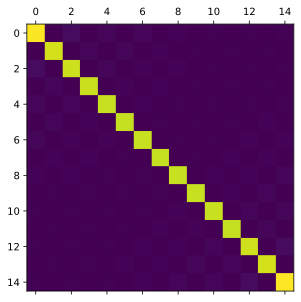

In [84]:
# Compare U_plus and U_plus dagger with U_+U_+ dagger
plt.matshow(np.real(quad_U_plus[4]))
plt.matshow(np.real(U_plus[4]@U_plus[4].conj().T))

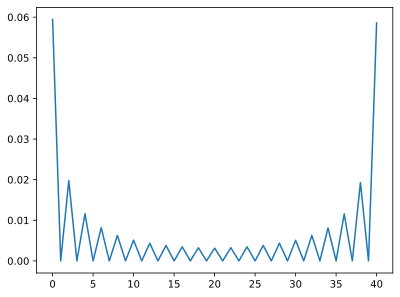

In [19]:
plt.plot(list(opt_pump[0]) + list(opt_pump[-1][1:]))

In [22]:
d_minus = scipy.linalg.svd(end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (2*N_z - 3)*N_omega:(2*N_z - 2)*N_omega])[1]
d_plus = scipy.linalg.svd(end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (N_z - 1)*N_omega:N_z*N_omega])[1]
d_minus_theory = scipy.linalg.svd(W_minus[-1])[1]
d_plus_theory = scipy.linalg.svd(W_plus[-1])[1]

In [49]:
U_plus = [end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, :N_omega], end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, N_omega:2*N_omega], end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (N_z - 2)*N_omega:(N_z - 1)*N_omega], ]
U_minus = [end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (2*N_z - 5)*N_omega:(2*N_z - 4)*N_omega], end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (2*N_z - 4)*N_omega:(2*N_z - 3)*N_omega], end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (2*N_z - 3)*N_omega:(2*N_z - 2)*N_omega]]
quad_U_plus = end_product[(N_z - 1)*N_omega:(2*N_z - 2)*N_omega,:(N_z - 1)*N_omega]
opt_pump = end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (2*N_z - 2)*N_omega:(2*N_z - 1)*N_omega]